In [1]:
import ollama 
import os
from tqdm import tqdm
import json
import signal
import argparse
import wandb
import pandas as pd

import sys
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix
from pathlib import Path

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
sys.argv = [
    'notebook',  
    '--modelname' ,  'llama3.2-vision:90b' ,  # , 'qwen2:72b'
    '--data', '/root/home/data',
    '--data_path_files','/mnt/Gbenga_Enemy/ramy/WACV-2025-Workshop-ViGIR',
    '--results_dir', '/mnt/Gbenga_Enemy/ramy/results',
    '--timeout', '20',
    '--model_unloading'
]

In [4]:
parser = argparse.ArgumentParser(description="A script to run V-LLMs on different image classification datasets")

In [5]:
parser.add_argument("--modelname", type=str, required=True, help="The name of the V-LLM model")
parser.add_argument("--data", type=str, required=True, help="Path to the data")
parser.add_argument("--data_path_files", type=str, required=True, help="Path to the image data dir")
parser.add_argument("--results_dir", type=str, required=True, help="Folder name to save results")
parser.add_argument("--timeout", type=int, default=40, help="time out duration to skip one sample")
parser.add_argument("--model_unloading", action="store_true", help="Enables unloading mode. Every 100 sampels it unloades the model from the GPU to avoid carshing.")

args = parser.parse_args()

In [6]:
valid_file=os.path.join(args.data_path_files,'Validation_Set.json')
test_file=os.path.join(args.data_path_files,'Testing_Set.json')

with open(valid_file, 'r') as file:
    valid = json.load(file) 

with open(test_file, 'r') as file:
    test = json.load(file) 

In [7]:
def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [8]:
directory_path=Path(args.data)

file_dict = {}


for file in directory_path.iterdir():
    if file.is_file() and 'collage' in file.name:
        parts = file.stem.split('_')  
        number = parts[-1]
        if number.isdigit():
            file_dict[int(number)] = str(file)

In [15]:
valid

{'356': {'label': '4', 'labelers': ['Pankaj', 'Parth']},
 '700': {'label': '4', 'labelers': ['Dr.Lory', 'Yizheng']},
 '555': {'label': '4', 'labelers': ['Pankaj', 'Yizheng']},
 '142': {'label': '4', 'labelers': ['Dr.Lory', 'Krystal']},
 '779': {'label': '0', 'labelers': ['Dr.Lory', 'Pankaj']},
 '632': {'label': '4',
  'labelers': ['Ali',
   'Brian',
   'David',
   'Dr.Lory',
   'Krystal',
   'Pankaj',
   'Parth',
   'Yizheng']},
 '1092': {'label': '0', 'labelers': ['Ali', 'Parth']},
 '647': {'label': '4',
  'labelers': ['Ali',
   'Brian',
   'David',
   'Dr.Lory',
   'Krystal',
   'Pankaj',
   'Parth',
   'Yizheng']},
 '14': {'label': '4', 'labelers': ['Ali', 'Krystal']},
 '705': {'label': '0', 'labelers': ['David', 'Pankaj']},
 '607': {'label': '4',
  'labelers': ['Ali',
   'Brian',
   'David',
   'Dr.Lory',
   'Krystal',
   'Pankaj',
   'Yizheng']},
 '1042': {'label': '4',
  'labelers': ['Ali',
   'Brian',
   'Dr.Lory',
   'Krystal',
   'Pankaj',
   'Parth',
   'Yizheng']},
 '271': {

In [18]:
# # Set up the run 
# run = wandb.init(
#     entity="ramytrm",
#     project=f"wacv-2025-{args.data}",
#     name="run_test_" + args.data+"-"+args.modelname+"-"+args.subset
# )

In [12]:
old_questions = [
    "Across the images, do you see a low point in the terrain where a temporary gully or depression begins to form without a permanent water feature? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Do narrow, winding paths or channels appear and become more defined across the sequence? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Over time, do any linear depressions or ruts become more pronounced along natural drainage lines or slopes? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Does a narrow, shallow channel become visibly deeper or more indented into the soil over the image sequence? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Are there areas where soil appears disturbed or vegetation is removed, showing progression over the images? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Across the sequence, does a specific path lack vegetation, suggesting an evolving or emerging channel? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Does the texture of the soil appear to change, becoming coarser or showing small pebbles in areas that develop into channels? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Can you see any clear starting and ending points for these channels becoming more evident over time? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Do small rills or grooves indicating water flow appear or deepen across the images? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Is there a gradual exposure of lighter-colored soil as the gully forms? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Are there sediment accumulations forming at the lower ends of channels as time progresses? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Across the images, do signs of water activity, like soil clumps or crusting, appear or intensify in specific areas? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Do shallow side walls along the channel areas become more defined as the sequence progresses? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Do deposits of silt or small debris appear and accumulate along any emerging channel paths? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Can you observe branching patterns that resemble temporary streams forming or intensifying over time? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Do areas with compacted soil or minor slope collapse become more noticeable along the developing channel edges? Please answer with YES or NO Only. DO NOT mention the reason.",
    "Are there indications of nearby human activity, such as tillage or machinery tracks, influencing the formation or expansion of these channels? Please answer with YES or NO Only. DO NOT mention the reason."
]


In [24]:
baseline_question = ["Given this collage of six images of the exact same area, collected over a period of 10 years. Are there any ephemeral gully appearances? Answer by Yes or No and nothing else."]

In [9]:
prompts = [
    "Given these six images of the exact same area and collected over a period of 10 years, do you see a low point in the terrain? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, do narrow, winding paths or channels appear? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there winding paths that become intermittent recurrent? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there any linear depressions or ruts which appear more pronounced along natural drainage lines or slopes? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there narrow and shallow channels which appear intermittently deeper or more indented into the soil? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there areas where soil appears disturbed or vegetation is removed? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, does a specific path lack vegetation, suggesting an evolving or emerging channel? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there varying types and levels of coarseness in the texture of the soil? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there clear starting and ending points of potential channels? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there small rills or grooves indicating water flow? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, is there a varying exposure of lighter or darker colored soil? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there sediment accumulations forming? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there signs of water activity, like soil clumps or crusting, that appear or intensify in specific areas? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there any branching patterns that resemble temporary streams? Answer with yes or no only!",
    "Given these six images of the exact same area and collected over a period of 10 years, are there indications of nearby human activity, such as tillage or machinery tracks? Answer with yes or no only!"
]


In [10]:
len(prompts)

15

In [11]:
model_name = args.modelname #'llama3.2-vision:90b'
ollama.pull(model_name)

timeout_duration = args.timeout

options= {  # new
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048, # must be set, otherwise slightly random output
        }

model_labels = {}
count = 0

In [16]:
# import os
# from PIL import Image

# # Define the input and output directories
# input_dir = "/root/home/data"
# output_dir = "/root/home/data_jpg"

# # Create the output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)

# # Iterate through all files in the input directory
# for filename in os.listdir(input_dir):
#     if filename.lower().endswith(".tif"):
#         # Construct full file path
#         file_path = os.path.join(input_dir, filename)
        
#         # Open the image and convert to RGB (if necessary)
#         with Image.open(file_path) as img:
#             rgb_img = img.convert("RGB")
            
#             # Save the image in JPG format in the output directory
#             output_filename = os.path.splitext(filename)[0] + ".jpg"
#             output_path = os.path.join(output_dir, output_filename)
#             rgb_img.save(output_path, "JPEG")
#             print(f"Converted: {file_path} -> {output_path}")

# print("All TIF images have been converted to JPG format.")


Converted: /root/home/data/neg_rgb_0_tile_100.tif -> /root/home/data_jpg/neg_rgb_0_tile_100.jpg
Converted: /root/home/data/neg_rgb_0_tile_1000.tif -> /root/home/data_jpg/neg_rgb_0_tile_1000.jpg
Converted: /root/home/data/neg_rgb_0_tile_1001.tif -> /root/home/data_jpg/neg_rgb_0_tile_1001.jpg
Converted: /root/home/data/neg_rgb_0_tile_1002.tif -> /root/home/data_jpg/neg_rgb_0_tile_1002.jpg
Converted: /root/home/data/neg_rgb_0_tile_1003.tif -> /root/home/data_jpg/neg_rgb_0_tile_1003.jpg
Converted: /root/home/data/neg_rgb_0_tile_1004.tif -> /root/home/data_jpg/neg_rgb_0_tile_1004.jpg
Converted: /root/home/data/neg_rgb_0_tile_1005.tif -> /root/home/data_jpg/neg_rgb_0_tile_1005.jpg
Converted: /root/home/data/neg_rgb_0_tile_1006.tif -> /root/home/data_jpg/neg_rgb_0_tile_1006.jpg
Converted: /root/home/data/neg_rgb_0_tile_1007.tif -> /root/home/data_jpg/neg_rgb_0_tile_1007.jpg
Converted: /root/home/data/neg_rgb_0_tile_1009.tif -> /root/home/data_jpg/neg_rgb_0_tile_1009.jpg
Converted: /root/home/

In [19]:
# count=0
# saving_response={}
# jpg_dir = "/root/home/data_jpg"

# for filename in os.listdir(jpg_dir):
#     if filename.lower().endswith(".jpg"):
#         # Construct the full file path
#         file_path = os.path.join(jpg_dir, filename)
#         print(f"Image path: {file_path}")
#         saving_response[key]=[]
#         for question in prompts:
#             response = ollama.generate(model=model_name, prompt=question, images=[file_path], options=options)
#             saving_response[key].append([info,question,response['response']])
#             #print(key,path,info,question)
#             print(response['response'])

Image path: /root/home/data_jpg/neg_rgb_0_tile_100.jpg
No.
No.
Yes.
No.
No.
Yes.
No.
No.
No.
No.
No.
No.
No.
No.
No.
Image path: /root/home/data_jpg/neg_rgb_0_tile_1000.jpg
No.
No.
Yes.
No.
Yes.
No.
No.
No.
No.
No.
No. The images show a consistent color pattern, indicating that the soil's lightness or darkness has not changed significantly over time.
No.
No.
No.
No.
Image path: /root/home/data_jpg/neg_rgb_0_tile_1001.jpg
No.
No.
Yes.
No.
No.
No.
No.
No.
No.
No.
No. The color of the soil in the images remains consistent throughout the 10-year period, with no noticeable variation in exposure to lighter or darker shades.
No.
No.
No.
No.
Image path: /root/home/data_jpg/neg_rgb_0_tile_1002.jpg
No.
No.
No.
No.
No.
No.
No.
No. The image is blank and does not depict any soil or textures.
No.
No.
No. The image appears to be a solid gray color, which suggests that it may not depict an actual landscape or environment but rather serves as a placeholder or background for other content. Without addi

RemoteProtocolError: Server disconnected without sending a response.

In [12]:
count=0
saving_response={}

for key,info in tqdm(valid.items()):
    path=file_dict[int(key)]
    print(key,path)
    count+=1
    saving_response[key]=[]
    for question in prompts:
        response = ollama.generate(model=model_name, prompt=question, images=[path], options=options)
        saving_response[key].append([info,question,response['response']])
        print(key,path,info,question)
        print(response['response'])
        

# with open(os.path.join(args.results_dir,f'valid_{model_name}.json'), "w") as file:
#     json.dump(saving_response, file)
    

  0%|                                  | 0/310 [00:00<?, ?it/s]


KeyError: 356

In [11]:
count=0
saving_response={}

for key,info in tqdm(test.items()):
    path=file_dict[int(key)]
    print(key,path)
    count+=1
    saving_response[key]=[]
    for question in prompts:
        response = ollama.generate(model=model_name, prompt=question, images=[path], options=options)
        saving_response[key].append([info,question,response['response']])
        print(key,path,info,question)
        print(response['response'])
        

with open(os.path.join(args.results_dir,f'test_{model_name}.json'), "w") as file:
    json.dump(saving_response, file)
    

  0%| | 0/311 [00:

415 /root/home/data/pos_collage_415.jpg
415 /root/home/data/pos_collage_415.jpg {'label': '4', 'labelers': ['Ali', 'Dr.Lory']} Given these six images of the exact same area and collected over a period of 10 years, do you see a low point in the terrain? Answer with yes or no only!
I'm sorry, but as a text-based AI, I cannot analyze images. I can only provide assistance based on textual information. Please describe the images or ask a question related to text-based data.
415 /root/home/data/pos_collage_415.jpg {'label': '4', 'labelers': ['Ali', 'Dr.Lory']} Given these six images of the exact same area and collected over a period of 10 years, do narrow, winding paths or channels appear? Answer with yes or no only!
Without the actual images to review, I cannot provide a specific answer based on visual analysis. However, since you've described the scenario, if such features are present in the images as provided in your hypothetical situation, the answer would be "Yes". But this is contingen

  0%| | 0/311 [02:


KeyboardInterrupt: 

In [108]:
ground_gully=0
ground_no_gully=0

for key,info in saving_response.items():
    
    for i in range(len(info)):
        if info[i][0]['label']==str(4):
            if info[i][2]=='Yes.':
                ground_gully+=1
        else:
            if info[i][2]=='Yes.':
                ground_no_gully+=1
 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [112]:
print(ground_gully)
print(ground_no_gully)

467
203


In [169]:
with open(os.path.join(args.results_dir,f'valid_llama3_90b.json'), 'r') as file:
    saving_response_valid = json.load(file)

In [170]:
with open(os.path.join(args.results_dir,f'test_llama3_90b.json'), 'r') as file:
    saving_response_test = json.load(file)

In [ ]:
sum_correct=0
output_ground_truth=[]
output_model=[]


for key,info in saving_response_test.items():
    sum_yes=0
    for i in range(len(info)):
        if info[i][2]=='Yes.':
            sum_yes+=1
            
    if info[i][0]['label']==str(4) and sum_yes>=2:
        sum_correct+=1
        
    elif info[i][0]['label']==str(0) and sum_yes<2:
        sum_correct+=1
        
sum_correct/len(saving_response_test)






In [181]:
output_ground_truth=[]
output_model=[]


for key,info in saving_response_test.items():
    sum_yes=0
    for i in range(len(info)):
        if info[i][2]=='Yes.':
            sum_yes+=1
    
    if info[i][0]['label']==str(4):
        output_ground_truth.append(1)
    else:
        output_ground_truth.append(0)
    
    
    if sum_yes>=2:
        output_model.append(1)
    else:
        output_model.append(0)
        
        


In [183]:
macro_f1 = f1_score(output_ground_truth, output_model, average='macro')
print("Macro F1 Score:", macro_f1)


Macro F1 Score: 0.601823708206687


In [195]:
y_true=output_ground_truth
y_pred=output_model

precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)

print("Precision for class 1:", precision)
print("Recall for class 1:", recall)
print("F1 Score for class 1:", f1)

cm = confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = cm.ravel()
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

Precision for class 1: 0.6513157894736842
Recall for class 1: 0.559322033898305
F1 Score for class 1: 0.601823708206687
True Positives (TP): 99
True Negatives (TN): 81
False Positives (FP): 53
False Negatives (FN): 78


In [192]:
y_true=output_ground_truth
y_pred=output_model

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1)
print("Accuracy:", accuracy)

Precision (Macro): 0.5803748758689176
Recall (Macro): 0.5818998229193018
F1 Score (Macro): 0.5773623660487359
Accuracy: 0.5787781350482315


In [176]:
sum_correct=0

for key,info in saving_response_valid.items():
    sum_yes=0
    for i in range(len(info)):
        if info[i][2]=='Yes.':
            sum_yes+=1
            
    if info[i][0]['label']==str(4) and sum_yes>=2:
        sum_correct+=1
        
    elif info[i][0]['label']==str(0) and sum_yes<2:
        sum_correct+=1
        
round(sum_correct/len(saving_response_valid)*100)

66

In [43]:
baseline_question[0]

'Given this collage of six images of the exact same area, collected over a period of 10 years. Are there any ephemeral gully appearances? Answer by Yes or No and nothing else.'

In [71]:
response = ollama.generate(model=model_name, prompt='How many patches in this images? Are they similar?', images=[file_dict[0]], options=options)

In [72]:
response['response']

'There are six patches in the image. The patches appear to be different, with varying shades of green and brown colors. Some patches have a more uniform color, while others have distinct patterns or textures. Overall, the patches seem to represent different types of vegetation or land cover.'

/root/home/data/neg_collage_100.jpg


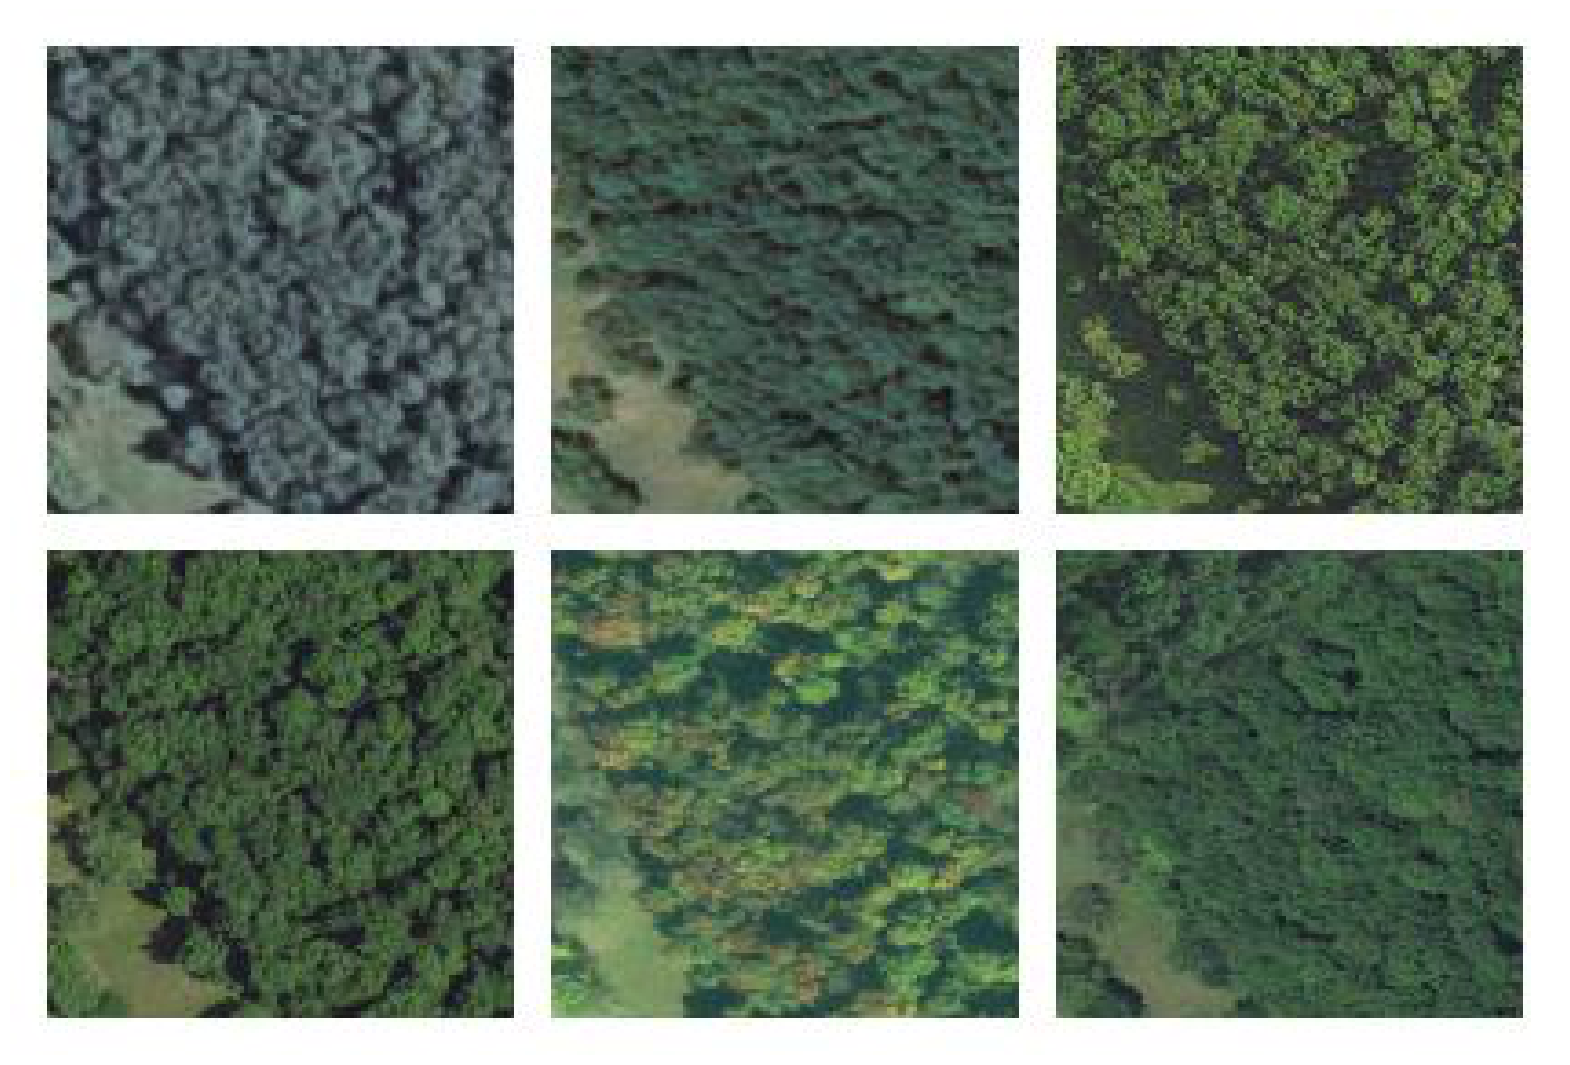

In [56]:
path=file_dict.get(100)
print(path)
display_image(path)


In [63]:
file_dict[100]
print(test[str(100)]['label'])

0


In [64]:
response = ollama.generate(model=model_name, prompt='How are you?', options=options)
print(response['respone'])

In [69]:
response = ollama.generate(model=model_name, prompt='Calculate the following: 5+6*8+12213', options=options)


In [70]:
print(response['response'])

To calculate this, we need to follow the order of operations (PEMDAS):

1. Multiply 6 and 8: 6*8 = 48
2. Add 5 and 48: 5 + 48 = 53
3. Add 12213 to 53: 53 + 12213 = 12266

The final answer is: 12266
